# Voynich Language Analysis

## Brian Kitano

## Introduction
Via [this blog post](https://voynichattacks.wordpress.com/2017/09/26/using-t-distributed-stochastic-neighbor-embedding-tsne-to-cluster-folios/), it appears that the Voynich Manuscript (VMS) might be written in two separate languages. In this paper, we will test different approaches on disambiguating noisy transcriptions of two mixed languages which use the same alphabet.

## Testing
In order to test our methods, we need to have a known sample document to analyze. Thus, we need to generate documents that are noisy, bilingual (or more), and mixed around. In VMS, it appears that the languages are separated by folio, so we’ll do the same here. Consider if we mixed it on a word to word basis then the sentences would be meaningless, and if we mixed it on a sentence to sentence basis the paragraphs would be meaningless, but if VMS is mixed folio by folio, the document at a whole would appear interpretable but jumbled. We will test each tier of mixing.

We'll first create a test document, which in this case will be Moby Dick, by Herman Melville. 

## Previous Work

Essentially all previous work has asked a similar, but significantly different question: "what languages are present?" This contrasts because theirs are recognition based, meaning they require both an assumption of what languages are present, and a corpus to train on. If they don't know what language is present, then their models don't work. However, I intend to exploit similar methods in order to determine the count present. In other words, all previous work is based on supervised training, whereas mine is (must be) based on unsupervised learning methods.

[statistical identification of language](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.48.1958&rep=rep1&type=pdf)

[natural language identification using corpus based methods](https://tidsskrift.dk/her/article/view/25083)

Other work includes being able to partition where one language ends and another begins (Rehurek and Kolkus, 2009), and have achieved significant success in that field. I believe this will be a subsidiary goal to my current one. 

In [1]:
import nltk
from nltk.tokenize import RegexpTokenizer
with open('/home/ubuntu/workspace/moby10b.txt') as fp:
    m = fp.read()
    
tokenizer = RegexpTokenizer(r'[A-Za-z0-9]+')
T_moby = map(lambda s: s.lower(), tokenizer.tokenize(m.replace("'",""))) # cleaned tokens of Moby Dick

## Top Down Approaches
### Test 1: Markov modeling for one language
This test is simple: we have a prior inclination that the document is in a language A. We set our null hypothesis to be “the document is not in language A”. We then reference the Markov model generated for Language A, and determine the probability, specified in [1]. If it’s significant enough, we can state that the document is in language A.  

#### Problem
Repeating this approach independently or in unison won’t work in determining whether something is in multiple languages. Consider the logical statements “A: D is in language A” and “B: D is in language B”, and the statement we wish to prove being that the document is in both A and B, A ^ B. If the languages are mutually exclusive, which by our test they are since we’d pick the language whose Markov model gives the highest likelihood, then P(A ^ B) = 0. Thus we need to consider a more nuanced definition of what it means for a document to be in two different languages.

Let’s try to more concretely define what it means for a document to be in two different languages. We first might consider the prevalence of words that are in each language being found in the document; if there are words found in multiple languages, that means that the document is in multiple languages. We can assign a metric to “how much language” it is in by looking at the ratio of the word counts from language A to all the others present. 

This definition has a balance of benefits and problems. On the benefits, it’s easy to calculate if you know what languages to look for, and it provides an intuitive summary statistic (“this is 20% English, 40% French, 40% Spanish). On the drawbacks, it requires us to know what languages to look for. This, in the context of the VMS, is a major problem, as we don’t even recognize the alphabet. In addition, this definition does not rely on the coherence of the document; a document might be a random distribution of words from randomly selected languages, and the metric would still be valid, despite the sentences being utterly incoherent. It suffices to say that we would like a method that does not depend on knowing what languages we need to look for, and can discern the difference between ‘a set of randomly ordered and selected words’ and ‘a sentence.’

### Test 2: Continuous Bag of Words Word Embeddings
This algorithm enables us to eliminate the known language dependency, and incorporate the relations between words present in the corpus we want to test, which enables us to distinguish between nonsense and meaningful sentences, in theory. 

Continuous Bag of Words (CBOW) embeddings rely on the Distributional Hypothesis,
Are there axes by which upon projecting down cluster to isolate verbs, nouns, adjectives?


## Analysis

### Building the Voynich dataset
The Voynich enhanced transcription dataset was acquired from [voynichese](https://github.com/voynichese/voynichese/blob/wiki/DataSets.md). The transcription uses EVA, which uses `a,c,d,e,f,g,h,i,k,l,m,n,o,p,q,r,s,t,v,x,y,z` as its alphabet.

In [2]:
from bs4 import BeautifulSoup
import nltk
import itertools

def folio_to_list(folio):

    with open('/home/ubuntu/workspace/data/' + folio) as fp:
        soup = BeautifulSoup(fp, 'html.parser')

    g = map(lambda _w: _w.string, soup.find_all('word'))
    
    return g

with open('/home/ubuntu/workspace/folio_list.txt') as fp:
    FOLIO_LIST = fp.readlines()
    
FOLIOS = map(lambda f: folio_to_list(f.split('\n')[0]), FOLIO_LIST)
T_vms = list(itertools.chain.from_iterable(FOLIOS)) # tokens of VMS

`T_vms` is a list of tokens. Let's learn some basic information about the VMS.

In [3]:
def make_alphabet(T): # determines the alphabet of a document from the list of tokens
    A = set()
    for word in T:
        for letter in word:
            A.add(letter)
    A.add(' ')
    return list(A)
        
def make_hash(A): # side tool for mapping letters to numbers, with space character inserted.
    H = dict( zip(A, range(len(A))))
    H[' '] = 0
    return H

For VMS, we have the following statistics:

In [4]:
print "word count: " + str(len(T_vms))
print "vocabulary size: " + str(len(set(T_vms)))
print "number of folios: " + str(len(FOLIO_LIST))

# determine the alphabet
A_vms = make_alphabet(T_vms)
print "alphabet: " + " ".join(A_vms)
H_vms = make_hash(A_vms)

word count: 37886
vocabulary size: 8078
number of folios: 225
alphabet:   a c e d g f i h k m l o n q p s r t v y x z


and for Moby Dick, we have

In [5]:
print "word count: " + str(len(T_moby))
print "vocabulary size: " + str(len(set(T_moby)))
A_moby = make_alphabet(T_moby)
print "alphabet: " + " ".join(A_moby)
H_moby = make_hash(A_moby)

word count: 218329
vocabulary size: 17585
alphabet:   1 0 3 2 5 4 7 6 9 8 a c b e d g f i h k j m l o n q p s r u t w v y x z


We'll also take a brief look at word frequency and token vs length.

###  Implementing the Algorithm
Our algorithm is broken into the following steps:
1. Take k n-length substrings from the document.
2. Calculate posterior bigrams for each substring.
3. Determine the optimal number of clusters via k-means and/or Gaussian Mixture Modeling.

Empirically, it might not be, but in the model it is.

Smoothing decreases the bias at the cost of increasing the variance.

In [162]:
import random
random.seed(100)

import numpy as np

def substring(T, n, Index=False):
    
    if type(T) == type([1,2]): # T is a word list
        S = ' '.join(T) # make a string of words
        if n > len(S):
            n = len(S)
        index = random.randint(0, len(S) - n)
        
        words_behind = len(S[:index].split(' ')) - 1
        
        if Index:
            return [ S[index:(index + n)], words_behind ]
        else: 
            return S[index:(index + n)]
        
    else: # it's a string
        if n > len(T):
            n = len(T)
        index = random.randint(0, len(T) - n)
        
        words_behind = len(T[:index].split(' ')) - 1

        if Index:
            return [T[index:(index + n)], words_behind]
        else: 
            return T[index:(index + n)]
    
def bigram(S, H, Smooth = 0):
    # returns the letter bigram of substring S given the alphabet
    
    l = len(H) # number of letters in alphabet
    B = np.zeros((l,l)) + Smooth
    
    prev = 0 # stores current index
    while prev < len(S) - 1:
        l_prev = S[prev] # the last letter
        l_curr = S[prev + 1] # the current letter
        
        i = H[l_prev]
        j = H[l_curr]
        
        # print "({0},{1})".format(l_prev,l_curr)
            
        B[i,j] += 1
        prev += 1
        
    return B / np.sum(B)

def trigram(S, H, Smooth = 0):
    # returns the letter trigram of substring S given the alphabet
    l = len(H)
    C = np.zeros((l,l,l)) + Smooth
    
    p = 0
    while p < len(S) - 2:
        l_pp = S[p]
        l_p = S[p+1]
        l_c = S[p+2]
        
        i = H[l_pp]
        j = H[l_p]
        k = H[l_c]
        
        C[i][j][k] += 1 # each element represents a unique trigram
        p += 1 # increment counter
        
    return C / np.sum(C)

In [7]:
S_moby = substring(T_moby, 200)
B_moby = bigram(S_moby, H_moby, Smooth=.001)

S_vms = substring(T_vms, 100)
B_vms = bigram(S_vms, H_vms)

C_moby = trigram(S_moby, H_moby)

In [395]:
aa = [lambda a: a.decode(encoding), A_vms]
print aa[1]

[' ', u'a', u'c', u'e', u'd', u'g', u'f', u'i', u'h', u'k', u'm', u'l', u'o', u'n', u'q', u'p', u's', u'r', u't', u'v', u'y', u'x', u'z']


Let's build a graphic to see visually what this means.

In [396]:
import matplotlib as mlp
import matplotlib.pyplot as plt

def bigram_graph(A, B, Labels=True):
    # A: alphabet (list), B: bigram
    fig, ax = plt.subplots(figsize=(7,7))
    
    cmap2 = mlp.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white','red','blue'],
                                               256)
    if Labels:
        ll = [lambda a: a.decode(encoding), A]
        plt.xticks(range(len(A)), ll[1])
        plt.yticks(range(len(A)), ll[1])


    img2 = plt.imshow(B,interpolation='nearest',
                        cmap = cmap2,
                        origin='lower'
                     )

    plt.colorbar(img2,cmap=cmap2) # this is the color bar
    
    plt.show()
    
def bigram_letter_analysis(B, H, A, l):
    index = H[l]
    t = list(B[index] / np.sum(B[index]))
    return t
    
def bigram_letter_analysis_graph(B, H, A, l):
    index = H[l]
    t = list(B[index] / np.sum(B[index]))
    
    fig, ax = plt.subplots()

    x = range(len(t))
    plt.bar(x, t)
    plt.xticks(x, [lambda a: a.decode(encoding), A])
    plt.ylabel("frequency")
    plt.xlabel("letter")
    plt.title("frequency of letter following '{0}'".format(l))

    plt.show()


In [397]:
print S_moby

ed towards each other and at the apex united in a tufted point where the loose hairy fibres waved to and fro like the top knot on some old pottowottamie sachems head a triangular opening faced towards


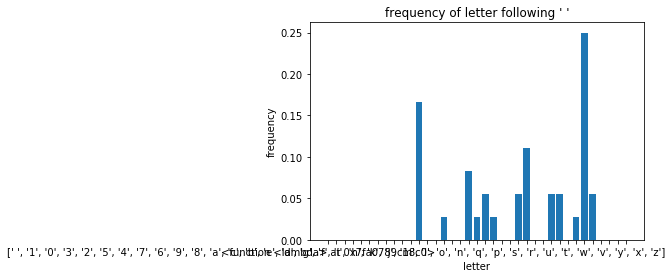

In [398]:
bigram_letter_analysis_graph(B_moby, H_moby, A_moby, ' ')

This is a bar graph is a slice of the bigram matrix down onto one dimension, where each bar represents the frequency of the letter following the slice. In this example, we use it to determine the most common letter following `' '`, the space character, which is thus the most common starting letter of a word.

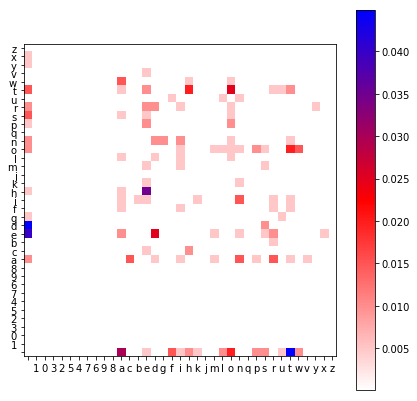

In [400]:
bigram_graph(A_moby, B_moby, Labels=True)

This is the full bigram matrix. Here, we can see that the most common bigrams are `'s '`, `' t'`, `'he'`, `'e '`. Note that the last three bigrams are the bigram decompositions of `the`, the most common word in the English language, and the first is just the fact that plurals typically end in `s`.

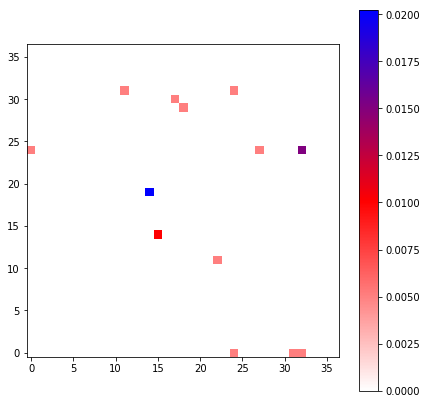

In [12]:
bigram_graph(A_moby, C_moby[H_moby['t']], Labels=False) # projecting a trigram down onto the bigram by slicing it

Here is a slice of the trigram matrix at letter `t`. The graph represents every observed trigram which starts with the letter `t`. The y-axis is the middle letter, and the x-axis is the ending letter. As you can see, as expected, the highest trigram is `the`, which is expected for English.

### Initial Comparisons between Voynichese and English
Let's look at the visual differences between two identically sampled substrings of English.

String 1: h virtue when lo comes cancer the crab and drags us back and here going from virtue leo a roaring lion lies in the path he gives a few fierce bites and surly dabs with his paw we escape and hail virgo the virgin thats our first love we marry and think to be happy for aye when pop comes libra or the 

String 2: lone whale as a solitary leviathan is called proves an ancient one like venerable moss bearded daniel boone he will have no one near him but nature herself and her he takes to wife in the wilderness of waters and the best of wives she is though she keeps so many moody secrets the schools composing n


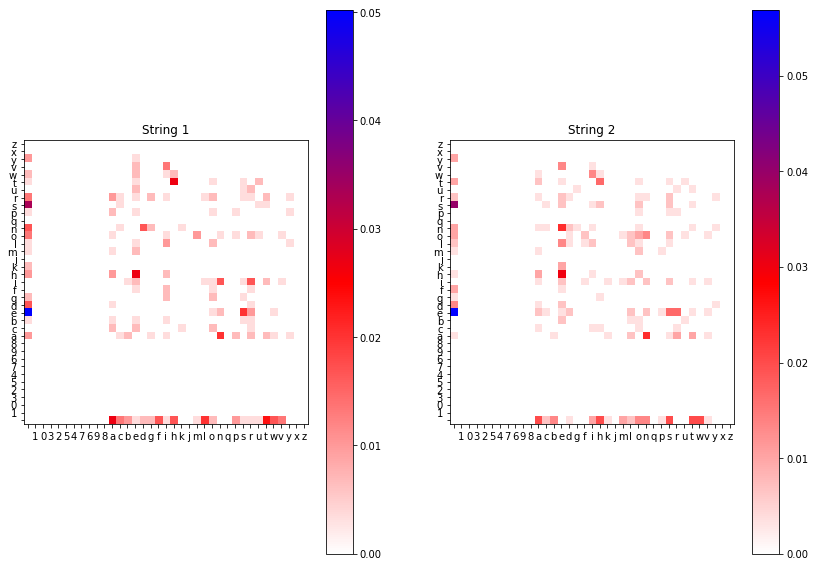

In [13]:
S_m1 = substring(T_moby, 300)
S_m2 = substring(T_moby, 300)

B_m1 = bigram(S_m1, H_moby)
B_m2 = bigram(S_m2, H_moby)

print "String 1: " + S_m1 + "\n"
print "String 2: " + S_m2

# A: alphabet (list), B: bigram
plt.subplots(figsize=(14,10))

ax1 = plt.subplot(1,2,1)
ax1.set_title("String 1")


cmap2 = mlp.colors.LinearSegmentedColormap.from_list('my_colormap',
                                           ['white','red','blue'],
                                           256)
plt.xticks(range(len(A_moby)), A_moby)
plt.yticks(range(len(A_moby)), A_moby)


img2 = plt.imshow(B_m1,interpolation='nearest',
                    cmap = cmap2,
                    origin='lower'
                 )

plt.colorbar(img2,cmap=cmap2) # this is the color bar

ax2 = plt.subplot(1,2,2)
ax2.set_title("String 2")

cmap2 = mlp.colors.LinearSegmentedColormap.from_list('my_colormap',
                                           ['white','red','blue'],
                                           256)
plt.xticks(range(len(A_moby)), A_moby)
plt.yticks(range(len(A_moby)), A_moby)


img2 = plt.imshow(B_m2,interpolation='nearest',
                    cmap = cmap2,
                    origin='lower'
                 )

plt.colorbar(img2,cmap=cmap2) # this is the color bar

plt.show()

Let's also determine a metric for the differences between two bigraphs: cosine similarity, given by $\cos(\theta) = \frac{A \cdot B}{|A||B|} $.

In [14]:
def sim(B1, B2):
    b1 = B1.reshape(1,-1)
    b2 = B2.reshape(1,-1)
    num = np.inner(b1,b2)
    den = np.sqrt(np.inner(b1,b1))*np.sqrt(np.inner(b2,b2))
    return num[0][0] / den[0][0]
    
print "Cosine simlarity: " + str(sim(B_m1, B_m2))

Cosine simlarity: 0.78238382985398


Here, we see that the bigrams are quite similar. These metrics can also be applied to the trigram, which is an empirically superior Markov model for language identification.

In [15]:
C_m1 = trigram(S_m1, H_moby)
C_m2 = trigram(S_m2, H_moby)

print "Cosine similarity: " + str(sim(C_m1, C_m2))

Cosine similarity: 0.4168454720894495


## Multiple Sampling
Our algorithm is based on being able to compare multiple bigrams or trigrams, and then cluster them. In order to do so, we need to take multiple n-grams, and then analyze the collection of samples. 

In [156]:
def streak(D, k, n, Scale=10, Read=False, Smooth=0, Show=False):
    if (Scale > k):
        Scale = k
    # D: document, n: length of strings to sample, k: number of samples
    l = 0
    D_alphabet = set()
    
    if type(D) == type([1,2]): # if D is the tokens
        D_alphabet = make_alphabet(D)
        l = len(D_alphabet)
    else: # if D is a string
        D_alphabet = make_alphabet(D.split(' ')) # tokenize
        l = len(D_alphabet)
        
    D_hash = make_hash(D_alphabet)
    M = np.zeros( ( k, l*l) )
    
    for i in range(k):
        S_i = substring(D, n)
        if Read:
            print "Sample {}: {}\n".format(i, S_i)
        B_i = bigram(S_i, D_hash, Smooth=Smooth).reshape(1, l*l)
        M[i][:] = B_i[:] 
        
    if Show:  
        fig, ax = plt.subplots(figsize=(k/Scale,l*l/Scale))

        cmap2 = mlp.colors.LinearSegmentedColormap.from_list('my_colormap',
                                                   ['white','red','blue'],
                                                   256)

        img2 = plt.imshow(np.transpose(M),interpolation='nearest',
                            cmap = cmap2,
                            origin='lower'
                         )

        plt.show()
    
    return M


Sample 0: mans two whales elsewhere in this volume the slanderous aspersion has been disproved that the vocation of whaling is throughout a slatternly untidy business but there is another thing to rebut they hi

Sample 1: i say that under such circumstances these ships should not only interchange hails but come into still closer more friendly and sociable contact and especially would this seem to be a matter of course 

Sample 2: ed with youthful life and begat him curly headed glories now when with royal tranquo i visited this wondrous whale and saw the skull an altar and the artificial smoke ascending from where the real jet

Sample 3: iron hoops this old ebony floundered along and in obedience to the word of command came to a dead stop on the opposite side of stubbs sideboard when with both hands folded before him and resting on hi

Sample 4:  and using it there without ceremony reaching over the table with it to the imminent jeopardy of many heads and grappling the beefsteaks towar

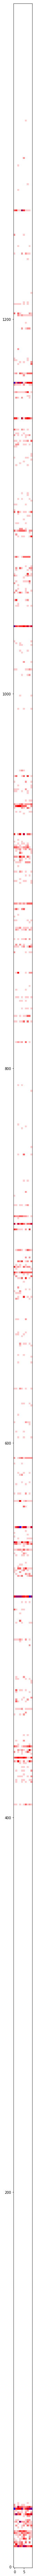

In [17]:
M = streak(T_moby, 10, 200, Scale=15, Read=True)

Text(0.5,1,'Variance of each bigram (max var: 0.00016565238251559303)')

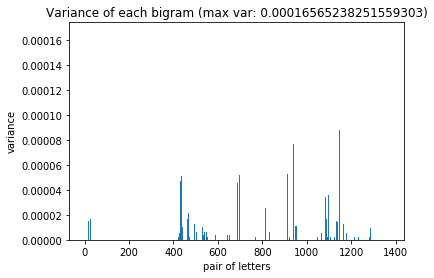

In [18]:
M_var = np.var(M, 0)

fig, ax = plt.subplots()

x = range(len(M_var))
plt.bar(x, M_var)
plt.ylabel("variance")
plt.xlabel("pair of letters")
plt.title("Variance of each bigram (max var: {0})".format( str(np.max(M_var)) ))

The streaking of similar hues across columns and in the same row is exactly what we'd expect for bigrams drawn from the same language. However, what we are also unsure of is what accounts for the variance in hues. In theory, if we took larger and larger samples, the contrast across streaks would diminish. We'll show this with 20 samples of 1000 characters.

Text(0.5,1,'Variance of each bigram (max var: 4.040827614401188e-05)')

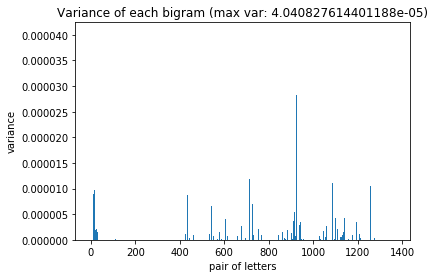

In [19]:
l = len(A_moby)

M2 = np.zeros( ( 20, 1369) )

for i in range(20):
    S_i = substring(T_moby, 1000)
    B_i = bigram(S_i, H_moby).reshape(1, 1369)
    M2[i][:] = B_i[:]
    
M2_var = np.var(M2, 0)

fig, ax = plt.subplots()

x = range(len(M2_var))
plt.bar(x, M2_var)
plt.ylabel("variance")
plt.xlabel("pair of letters")
plt.title("Variance of each bigram (max var: {0})".format( str(np.max(M2_var)) ))


To reinforce the measures (and to have a better visual comparison for the multilingual samples), we'll also use t-SNE (t-distributed Stochastic Neighbor Embeddings) to display our streak chart in 2D.

[1.92242142e-01 1.42911213e-01 1.26832444e-01 1.17204615e-01
 1.10609220e-01 9.46588038e-02 7.99749727e-02 7.15914997e-02
 6.39750904e-02 3.34880508e-32]


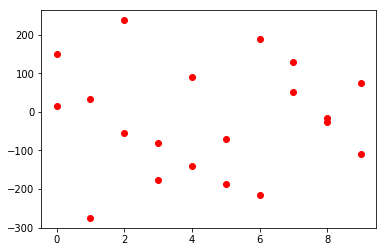

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA()
pca.fit(M) # reduce down to 50 dimensions
M_p = pca.transform(M)
print pca.explained_variance_ratio_

M_embedded = TSNE(n_components=2).fit_transform(M_p)

plt.plot(M_embedded, 'ro')

Now, this plot above really doesn't mean anything since these values are all from the same bigram distribution (English). We now need to work with multilingual data and see if this works.

## Sampling from Shuffled Multilingual Documents
We will now create a set of multilingual test documents, using the [Cross Language Dataset](https://github.com/FerreroJeremy/Cross-Language-Dataset), which is a collection of English, French, and Spanish sentences and documents. For our purposes, we will create monolingual documents first, and show that the bigram streak charts are sufficiently different to partition them. 

In particular, to construct a multilingual document, we'll use a model inspired by Latent Dirichlet Allocation. We will choose a mixture parameter $\textbf{p} = (p_1, p_2, ..., p_N)$ where $N$ is the number of languages we are mixing. We will use $\textbf{p}$ as the parameter for a multinomial distribution $L_{\textbf{p}}$. Then, from this multinomial distribution, we will draw the language that a sentence is from. Finally, we will choose a sentence from the sentence bank in that language, and append it to the document. 

If we wanted to generalize the document-generating process, we could draw $\textbf{p}$ from a Dirichlet distribution with parameter $\alpha$, which would determine how evenly distributed the languages are within the corpus, though this step is frankly extra and unnecessary.

In [21]:
import unidecode # for removing diacritics in spanish and french (do i actually need to? I think not!)
from string import punctuation # for removing punctuation

# import sys  
# reload(sys)  
# sys.setdefaultencoding('utf8')

with open('/home/ubuntu/workspace/Europarl/en_manifest.txt') as fp:
    EN_MANIFEST = fp.readlines()

with open('/home/ubuntu/workspace/Europarl/es_manifest.txt') as fp:
    ES_MANIFEST = fp.readlines()

with open('/home/ubuntu/workspace/Europarl/fr_manifest.txt') as fp:
    FR_MANIFEST = fp.readlines()
    
MANIFEST_LIST = [EN_MANIFEST, ES_MANIFEST, FR_MANIFEST]
languages = ['en', 'es', 'fr']

def document(p, s, Shuffle=False, Labels=False):
    # p is an N x 1 array, where N is the number of languages. 
    # this will return a string with s sentences in various languages.
    
    m = np.random.multinomial(s, p) # the number of sentences from each language
    
    lang_codes = [] # stores the language codes corresponding to those sentences
    S = [] # stores the sentences
    
    for i in range(len(m)): # for each language
        lang_count = m[i] # the number of sentences in that language will appear
        lang_code = languages[i] # the language code
        lang_list = MANIFEST_LIST[i] # the language manifest
        w = random.sample(lang_list, lang_count) # pick lang_count sentences from the lang_list
        S.extend([ sentence.split('*\n')[0] for sentence in w ])
        lang_codes.extend([ lang_code for j in range(lang_count) ] )
    
    P = zip(lang_codes, S)
    if Shuffle:
        random.shuffle(P)
    
    sentence_list = []
    labels = []
    
    for pair in P:
        lang_code = pair[0]
        file_name = pair[1]
        with open('/home/ubuntu/workspace/Europarl/{0}/{1}'.format(lang_code, file_name)) as sent_doc:
            sent_doc_list = sent_doc.readlines()
            sent = random.sample(sent_doc_list, 1)[0]
            
            tokenizer = RegexpTokenizer(r'[^{0} ]+'.format(punctuation)) # removes all punctuation (with some exceptions)
            T_sent = map(lambda s: s.lower().strip(), tokenizer.tokenize(
                sent
                .replace("'","")
                .replace('\xe2\x80\x99','') # another quotation encoding
                .replace('\xc2\xab','') # french left quotation
                .replace('\xc2\xbb','') # french right quotation
                .replace('\xc2\xb0','') # degree sign
                .replace('\xc2\xbf','') # spanish upside down question mark
                .replace('\xc2\xba','') # other degree sign
                .replace('\xc2\xa1','') # spanish exclamation point
            )) # cleaned tokens of the sentence
            T_sent_cleaner = filter(None, T_sent) # remove null characters
            
            # add a word to language tagger
            label = [lang_code for i in range(len(T_sent_cleaner))]
            labels.extend(label)
            
            t = ' '.join(T_sent)
            sentence_list.append(t[:-1])
    
    d = ' '.join(sentence_list)
    
    if(Labels):
        return [d, labels]
    else:
        return d

In [22]:
[D, labels] = document([.3,.4,.3], 10, Shuffle=True, Labels=True)
print D
print zip(D.split(' '), labels)

discharge 2005 section viii b european data protection supervisor vote report caspar la modulación facultativa implicaría transferir fondos del gasto obligatorio del presupuesto de la ue al gasto no obligatorio la unión europea todavía es demasiado dependiente en particular en lo referente a sus importaciones de gas ya que para 2020 probablemente tendrá que importar aproximadamente el 80 de su gas we could invite morgan tsvangirai to come to a meeting of the committee on foreign affairs and the committee on development in july or september at present when there are more than 23 million unemployed cohesion policy is one of the policies that can also contribute to creating new jobs human rights and the rule of law are also important aspects upon which we should concentrate as is the case for our other neighbours including belarus for example de mr president ladies and gentlemen i believe it is important alongside our wide ranging cooperation in the field of business and in the face of gl

Okay, we've now created a function that creates a document of multiple languages, given the parameters of a multinomoal distribution, and the number of sentences in the document. We can also determine whether to shuffle the languages or not. Further, we can create tagged versions of the document which label each word with the language it was drawn from. We'll now show some simple examples of our document generator.

In [23]:
# english only document
print 'english:\n' + document([1.,0.,0.], 10) + '\n'

# spanish only document
print 'spanish:\n' + document([0.,1.,0.], 10) + '\n'

# french only document 
print 'french:\n' + document([0.,0.,1.], 10) + '\n'

# two parts english to one part spanish, shuffled
print 'mixed:\n' + document([2/3.,1/3.,.0], 10, Shuffle=True) + '\n'

english:
closure of the sitting la seduta è tolta alle 00 25 we gathered from his appearance here on 24 june that he was not thinking of embarking on an ambitious reform under any circumstances and that he would confine himself to the conventional measures mrs in t veld i have a question at the precarious times we are facing now which we have heard already in this parliament it is important that we discuss these matters as fully as we can we are now trying to cushion this with eur 500 million annually which will not be enough indeed i had thought that all the political groups in this house were agreed upon the resolution the second written declaration has been submitted by mrs hall mrs ayala sender mrs durant mr koch and mrs wils on heavy goods vehicle collisions in this report we are again calling on the united states but also on india and china to ratify the kyoto protocol and to join with the european union in taking responsibility for sustainable development worldwide mandate for t

Let's now write a wrapper which autogenerates the necessary info for bigrams (or trigrams).

In [149]:
def auto_info(D):
    D_tokens = D.split(' ') # tokenizes the document
    D_alphabet = make_alphabet(D_tokens)
    D_hash = make_hash(D_alphabet)
    return [D_alphabet, D_hash, len(D), len(D_tokens), len(set(D_tokens))]

37
á claro que el futuro del sistema de transporte europeo pasa imperativamente por la revitalización rápida del sector ferroviario la suerte de las mujeres en algunas provincias bajo su control no no


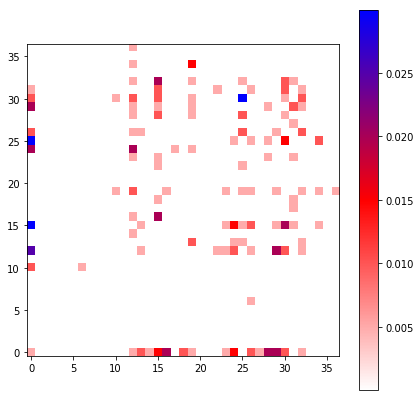

In [82]:
[D3, labels] = document([1/2., 1/2., 0.], 10, Labels=True, Shuffle=True)
[D_alphabet, D_hash, char_length, word_length, vocab_size] = auto_info(D3)

print len(D_alphabet)

s = substring(D3, 200)
print s
B_s = bigram(s, D_hash, Smooth=.001)
bigram_graph(D_alphabet, B_s, Labels=False)

Because of some unicode to ascii encoding issues, I can't label the graphs, but they are effectively the same.

Sample 0: eo pasa imperativamente por la revitalización rápida del sector ferroviario la suerte de las mujeres en algunas provincias bajo su control no nos permite albergar el sosiego the territorial integrity of georgia is guaranteed by 36 un resolutions adopted in 1993 secondly if we consider as you claim

Sample 1: no nos permite albergar el sosiego the territorial integrity of georgia is guaranteed by 36 un resolutions adopted in 1993 secondly if we consider as you claim that this is not a matter for the european union i would like to understand why these matters are included in the copenhagen criteria and wh

Sample 2: rte de las mujeres en algunas provincias bajo su control no nos permite albergar el sosiego the territorial integrity of georgia is guaranteed by 36 un resolutions adopted in 1993 secondly if we consider as you claim that this is not a matter for the european union i would like to understand why the

Sample 3: ión rápida del sector ferroviario la suerte de las mujer

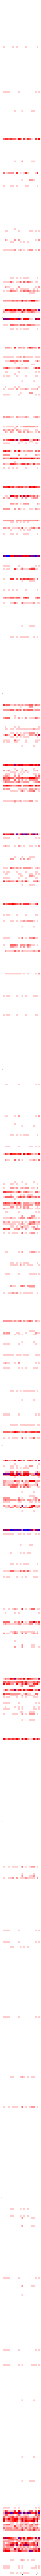

In [83]:
M = streak(D3, 10, 300, Scale=2, Read=True, Smooth=.001)

It'd be nice if we could visually tag the languages, and then be able to determine our error rate later.

In [126]:
ANSI = {'en':'\033[1;31;1m', 'es':'\033[1;32;1m', 'fr':'\033[1;34;1m'} # codes for colored text output by language

def supervised_print(string, labels):
    # string:  a string, n: length of strings to sample, labels: labels of words
    if type(string) == type('string'):
        Words = string.split(' ')
    
    sl = set(labels)
    d = dict(zip(sl, range(len(sl))))
    
    pstring = []
    for i in range(len(Words)):
        label = labels[i] # the label for that word
        colorCode = ANSI[label] # the color for that index
        coloredWord = colorCode + Words[i] # color the word
        pstring.append(coloredWord) # add it to the list
    return ' '.join(pstring) + '\033[1;34;0m' # turn the list into a string and reset the color
    


In [133]:
[D1, L1] = document([.3,.4,.3], 10, Shuffle=True, Labels=True)
print supervised_print(D1, L1)

nous étions conscients quil subsistait une pénurie de quelque 100 000 ingénieurs et chercheurs en europe et que nous ne pouvions pas stimuler linnovation simplement par le biais dincitants directs et de projets le vote aura lieu jeudi 19 février 2009 ayer domingo 11 de marzo se cumplió el tercer aniversario del atentado terrorista ocurrido en madrid el 11 de marzo de 2004 que causó la muerte de 192 personas et il y a urgence madame la commissaire mt monsieur le président la décision de la cour européenne nest pas tant une condamnation de la belgique ou de la grèce quune condamnation du règlement de dublin parce que cest bien ce règlement qui a permis à la belgique de renvoyer un ressortissant afghan en grèce resumption of the session i declare resumed the session of the european parliament adjourned on thursday 25 february 2010 a pesar de todo el plan de la liga Árabe sigue siendo por el momento la única iniciativa que podría contribuir a la resolución de la parálisis política del país

Now, to modify the streak chart in order to incorporate the word coloring:

In [134]:
def mod_streak(D, labels, k, n, Scale=10, Read=False, Smooth=0, Show=False):
    T = D.split(' ')
    # D: document string, n: length of strings to sample, k: number of samples
    D_alphabet = set()
    
    D_alphabet = make_alphabet(D) # tokenize
        
    l = len(D_alphabet)
        
    D_hash = make_hash(D_alphabet)
    M = np.zeros( ( k, l*l) )
    
    for i in range(k):
        [S_i, index] = substring(T, n, Index=True) # index is corresponding to a character, not a word.
        labels_i = labels[index : ( index + len(S_i.split(' ')) )]
        
        if Read:
            print "Sample {}: {}\n".format(i, supervised_print(S_i, labels_i))
        B_i = bigram(S_i, D_hash, Smooth=Smooth).reshape(1, l*l)
        M[i][:] = B_i[:] 
        
    if Show:
        fig, ax = plt.subplots(figsize=(k/scale,l*l/scale))

        cmap2 = mlp.colors.LinearSegmentedColormap.from_list('my_colormap',
                                                   ['white','red','blue'],
                                                   256)

        img2 = plt.imshow(np.transpose(M),interpolation='nearest',
                            cmap = cmap2,
                            origin='lower'
                         )

        plt.show()
    
    return M


In [135]:
test = mod_streak(D1, L1, 20, 100, Read=True)

Sample 0: ects et de projets le vote aura lieu jeudi 19 février 2009 ayer domingo 11 de marzo se cumplió el 

Sample 1: ement par le biais dincitants directs et de projets le vote aura lieu jeudi 19 février 2009 ayer do

Sample 2: bstenu lors du vote final et jai voté contre ce que lon a appelé la troisième solution concernant

Sample 3: biais dincitants directs et de projets le vote aura lieu jeudi 19 février 2009 ayer domingo 11 de m

Sample 4: entrer sur lharmonisation du degré douverture des marchés nationaux it monsieur le président je m

Sample 5: elle le rapport de m je considère quil est très important et hautement symbolique que jouvre cette

Sample 6: r domingo 11 de marzo se cumplió el tercer aniversario del atentado terrorista ocurrido en madrid e

Sample 7: libre concurrence dans ce marché me han pedido ayuda no solo las 20 000 federaciones fuertes de vit

Sample 8: ré douverture des marchés nationaux it monsieur le président je me suis abstenu lors du vote fina

Sample 9:

In the test above, you can clearly see that these sample strings are too 'mixed' to extract a coherent set of bigrams. 'Mixed' here refers to a few phenomena: first, the sentence bank from which we draw contains sentences that are very brief at times; second, the shuffling of the sentences is too thorough, and thus each draw of a random substring is hitting on a break point; and third, the length parameter of the substring is too high, so it increases the probability of hitting on a break point. Ideally, we avoid editing our test bank, as that would constrain our application even farther. Instead, we can limit the mixing of our documents by changing the parameters of the multinomial distribution or setting `Shuffle=False` parameter in our `document` function. In addition, we could also limit the length of the substrings, but I fear that this would limit the ability of the bigrams to converge effectively. 

Now that we have the tools to build our dataset and visually understand the algorithms at work, we now need to come up with the tests for determining how many languages are in a document. The main idea here is that from the bigram matrices we've sampled, if the bigram matrices are sufficiently different, then we assume there are multiple languages present. Furthermore, if there are multiple languages present, we want to be able to count how many are present. 

Let's first recall that the bigram matrices are estimates of a Markov model's state transition matrix, which thus represent probabilities. We can thus consider each matrix a probability distribution. We want to test how similar each of our distributions are, and thus a natural test will be a pairwise symmetric KL Divergence test (psKLD). The KL Divergence is a measure of how similar two probability functions are. We'd expect that if there were one language present, then the psKLD plot will on average measure a very low number, with a unimodal distribution. However, if there were more than one language, we'd expect a distribution with $\binom{n}{2}$ modes, where $n$ is the true number of languages present. 

A second approach is to consider each matrix a random variable drawn from a language-dependent distribution. In this scenario, each language has a true bigram matrix, and any substring is an approximation of it, where the variance can be accounted for by word choice or other negligent latent variables. In this context, we'd want to use a high-dimensional Gaussian Mixture Model (GMM) to determine the number of Guassian distributions of matrices present in our document, where each Gaussian distribution corresponds to a language.

### psKLD

To implement psKLD, we'll need to build a function which takes in a streak chart, and for each pair computes the psKLD. We'll then plot them and see what happens. We'll test this on six types of documents: shuffled vs. unshuffled, and one language, two languages, or three languages. We'll keep the document length fixed at $m = 30$ sentences, and we'll create a corpus of 20 documents.

In [410]:
one_unshuffled = [ document([1.,0.,0.], 30, Labels=True) for i in range(20) ]
two_unshuffled = [ document([.5,.5,0.], 30, Labels=True) for i in range(20) ]
three_unshuffled = [ document([1/3.,1/3.,1/3.], 30, Labels=True) for i in range(20) ]
two_shuffled = [ document([.5,.5,0.], 30, Labels=False, Shuffle=True) for i in range(20) ]
three_shuffled = [ document([1/3.,1/3.,1/3.], 30, Labels=False, Shuffle=True) for i in range(20) ]

We'll need to build a tool to measure the psKLD given a streak graph. The formula for psKLD is given by 
$$
H(p,q) = \sum_{x \in X} p(x) \log_2 \frac{p(x)}{q(x)} + \sum_{x \in X} q(x) \log_2 \frac{q(x)}{p(x)},
$$
where $p$ and $q$ are probability functions over a space $X$. When $p = q$, then the $\frac{p(x)}{q(x)} = 1$, so the $\log$ term will be 0, and thus the divergence will be 0. Note, however, that the KL divergence is always positive by Gibb's Inequality. We can rexpress this as 
$$
H(p,q) = \sum_{x \in X} \left(p(x)-q(x)\right) \log_2 \frac{p(x)}{q(x)},
$$
which is easier to see as always positive. 

We'll now implement it.

In [181]:
def H(p,q):
    # p and q are bigram matrix samples
    h = np.sum( (p - q) * np.log(np.divide(p, q)) )
    return h
    
def psKLD(M, k):
    d = []
    for i in range(k): # for each sample bigram in a streak
        p = M[i,:]
        for j in range(i+1,k): # for each sample ahead in the streak
            d.append(H(p, M[j,:])) # store the KLD
            
    return np.array(d)
            

Let's begin with the `one_unshuffled` corpus. It's insightful to know the lengths of the documents we are working with, so let's determine the character and word lengths, as well as the vocabulary sizes now. 

In [155]:
# [character length, word length, vocab size]
one_unshuffled_stats = np.array([ auto_info(one_unshuffled[i][0])[2:] for i in range(len(one_unshuffled))])
print one_unshuffled_stats, np.sum(one_unshuffled_stats, axis=0)

[[4844  850  439]
 [5768  984  467]
 [6133 1047  503]
 [5388  904  456]
 [6286 1040  531]
 [6918 1190  525]
 [5547  934  478]
 [6520 1072  519]
 [4306  756  391]
 [4091  712  374]
 [4143  681  389]
 [7345 1202  515]
 [5643  944  473]
 [5279  917  449]
 [5095  857  427]
 [4210  715  407]
 [5035  871  431]
 [4569  766  403]
 [4838  799  419]
 [5370  915  455]] [107328  18156   9051]


In [313]:
def index_to_coord(i, cols):
    r = i / cols
    c = i % cols
    return [r,c]

Each of these documents is roughly 2.5% the length of VMS in terms of word length, and has a vocab size of around 5% of the VMS, for some perspective. They're about 5 times as long as the average folio.

For each of the 20 documents in the corpus, we'll take $k$ samples of $n$-length substrings. We can determine the optimal $n$ via cross validation later, but for now we'll set $k = 50$ and $n = 175$, which was derived in other literature. Thus, over the entire corpus of 20 documents (100k characters, 18k words), we'll be taking 1000 samples and in total about 175k characters. This obviously means we'll be sampling most letters twice, and I'm not sure how that impacts things. Ideally, when we look at a histogram of the psKLD, it should be unimodal, since these are all from the same language. Things are getting redundant.

In [375]:
k = 50
n = 175

D1 = []
for i in range(len(one_unshuffled)):
    M_i = streak(one_unshuffled[i][0], k, n, Smooth=.01) # make a streak
    d_i = psKLD(M_i, k) # do the pointwise psKLDs
    D1.append(d_i)
    
D1 = np.array(D1)


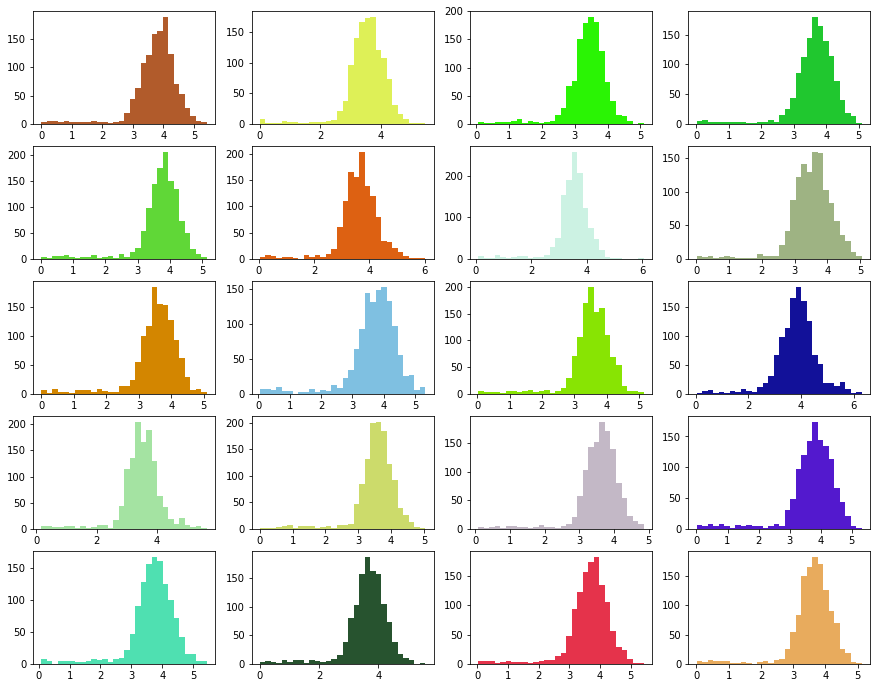

In [376]:
cols = 4
f, axarr = plt.subplots(5, cols, figsize=(15,12)) # 5 rows, 4 cols for 20 doc histograms in corpus
for i in range(D1.shape[0]): # for each document
    coor = index_to_coord(i, cols)
    color = list(np.random.rand(3))
    axarr[coor[0], coor[1]].hist(D1[i], bins=30, color = color) # can go as high as 50 bins

In [377]:
medians = np.array( [ np.median(D1[i]) for i in range(D1.shape[0]) ] )
print medians

[3.84339721 3.57004225 3.46076016 3.70139576 3.80979276 3.6726051
 3.56879177 3.55673505 3.61228789 3.77967876 3.57942949 3.87060085
 3.50943877 3.58902466 3.6444078  3.82843528 3.76316576 3.68619519
 3.73857472 3.65713868]


What we'd expect further is that if we increase $n$, the length of the substrings, our mean would get closer to 0. Let's check the two language unshuffled corpus.

In [214]:
k = 50
n = 175

D2 = []
for i in range(len(two_unshuffled)):
    M_i = streak(two_unshuffled[i][0], k, n, Smooth=.01) # make a streak
    d_i = psKLD(M_i, k) # do the pointwise psKLDs
    D2.append(d_i)
    
D2 = np.array(D2)

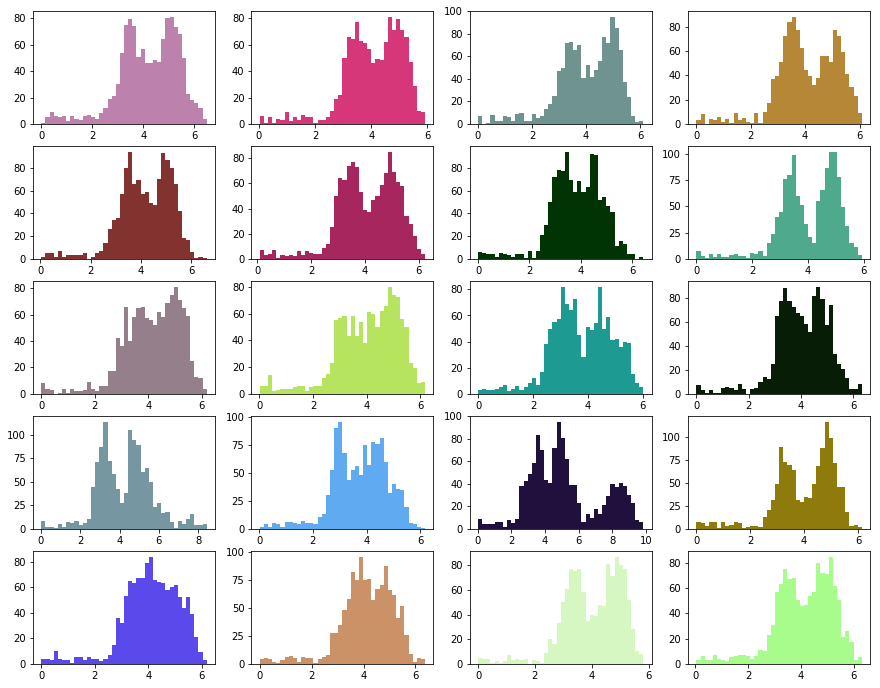

In [309]:
cols = 4
f, axarr = plt.subplots(5, cols, figsize=(15,12)) # 5 rows, 4 cols for 20 doc histograms in corpus
for i in range(D2.shape[0]): # for each document
    coor = index_to_coord(i, cols)
    color = list(np.random.rand(3))
    axarr[coor[0], coor[1]].hist(D2[i], bins=40, color = color)    

Haha! Two modes! We're really cooking! If my hypothesis is correct, how many modes should we see for a document with $n$ languages? Since we are looking at pairs of languages, we should expect to see $\binom{n}{2}$, and in addition the null difference between a language and itself, thus $\binom{n}{2}+1$ modes for $n$ languages. Thus for a trilingual document, we should see $\binom{3}{2} + 1 = 4$ modes.

In [257]:
k = 50
n = 175

D3 = []
for i in range(len(three_unshuffled)): # there are 20 documents in the corpus
    M_i = streak(three_unshuffled[i][0], k, n, Smooth=.01) # make a streak for each document
    d_i = psKLD(M_i, k) # do the psKLDs within each document
    D3.append(d_i) # store the psKLD array in D3
    
D3 = np.array(D3) # will be [D x 1 x (n 2)]

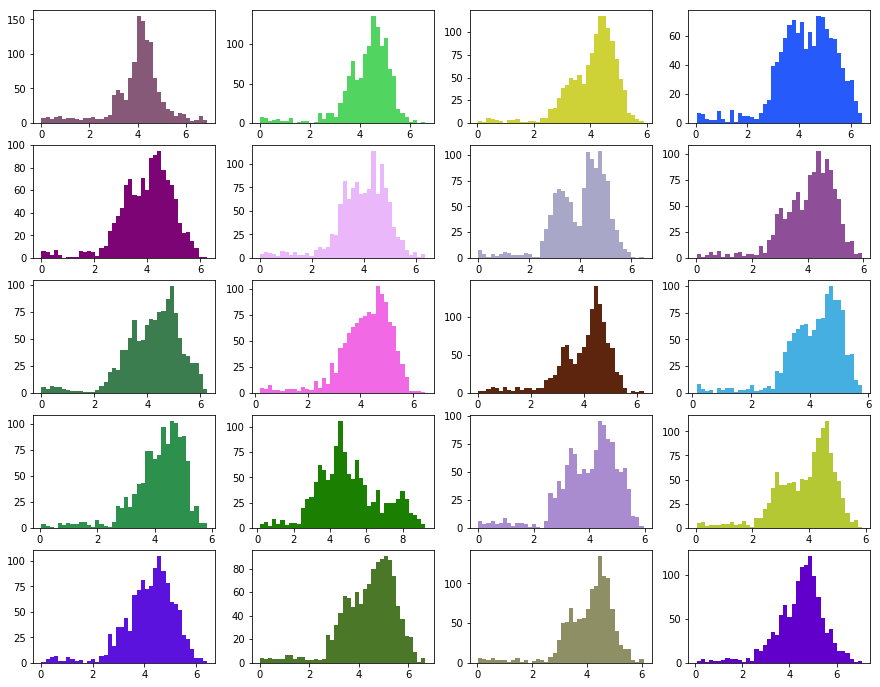

In [308]:
cols = 4
f, axarr = plt.subplots(5, cols, figsize=(15,12)) # 5 rows, 4 cols for 20 doc histograms in corpus
for i in range(D3.shape[0]): # for each document
    coor = index_to_coord(i, cols)
    color = list(np.random.rand(3))
    axarr[coor[0], coor[1]].hist(D3[i], bins=40, color = color)    

I believe I need to explain further as we get more and more abstracted from the actual text: each histogram represents the total counts of observed psKLD's between two bigram matrices, which represent probability distributions of bigrams, which are approximate characterisations of languages. Perhaps I should include the documents that each one of these histograms are derived from. Effectively, each histogram is a visual representation of the mix of languages present.

In [232]:
three_unshuffled_a = [ document([1/3.,1/3.,1/3.], 100, Labels=True) for i in range(20) ]

Sample 0: n a hong kong no les parece que hay razones especiales para progresar en relación con esta cuestión con lo cual se fortalecerían las relaciones entre la unión europea y ho

Sample 1: ust señora presidenta señor comisario estimadas y estimados colegas yo también quiero felicitar a nicholas clegg por su intenso trabajo estoy muy agradecida por el hecho de

Sample 2: s in venezuela the debate is closed collection and management of data on the common fisheries policy vote report paulo casac on behalf of the gue ngl group nl mr president dur

Sample 3: van a hong kong no les parece que hay razones especiales para progresar en relación con esta cuestión con lo cual se fortalecerían las relaciones entre la unión europea y 

Sample 4:  por 3 días roger knapman por 3 días hans peter martin por 3 días y philippe de villiers por 3 días el parlamento europeo participa activamente en el diálogo continuo con

Sample 5: ther limitation of citizens rights in venezuela the debate is closed co

Sample 74: endum le vote aura lieu le mercredi 24 octobre le commissaire Špidla qui a fait de lexcellent travail dans des circonstances difficiles demande en fait aux États membres aux

Sample 75: or the authorisation of gmos on behalf of the pse group fr mr president commissioner ladies and gentlemen during our last debate in july on access to medicines i concluded my 

Sample 76:  lo cual se fortalecerían las relaciones entre la unión europea y hong kong y por ende entre europa y china consigamos esa base jurídica que en el futuro nos permita actuar

Sample 77: 3 días roger knapman por 3 días hans peter martin por 3 días y philippe de villiers por 3 días el parlamento europeo participa activamente en el diálogo continuo con repr

Sample 78: ducción de la primera mitad de 1998 comparada con la primera mitad del amo 1997 los siguientes han perdido el derecho a las dietas jim allister por 3 días godfrey blum por 2

Sample 79: de la gestión 2009 eurojust señora presidenta señor comisario

Sample 139: medicines i concluded my comments by calling on the council and the commission to make clear and formal commitments that would guarantee europes active involvement in finding 

Sample 140: las clegg por su intenso trabajo estoy muy agradecida por el hecho de que esta resolución haya sido apoyada por todos los grupos de la cámara corrigendum au procès verbal d

Sample 141: �n Ártica y como presidente de la delegación sineea represento al parlamento europeo en este importante organismo no hay necesidad de volver a plantear el debate no sé si s

Sample 142: our la lituanie mais aussi pour lensemble de leurope le marquage dorigine obligatoire des biens dimportation pourrait nous y aider directement ou indirectement interopérabili

Sample 143: e european globalisation adjustment fund aragón retail trade from spain situación de los derechos fundamentales en la unión europea 2004 2008 antes de proceder a la votaci�

Sample 144:  lensemble de leurope le marquage dorigine obligatoir

Sample 207: o 32 señor presidente es para completar el texto de esta enmienda en vista de que las autoridades de hong kong se han esforzado denodadamente por conseguir que su documento d

Sample 208: sents more than 20 of the population and this is tending to rise because of the steady increase in life expectancy resumption of the session i declare resumed the session susp

Sample 209:  with regard to collective passenger transport criminal justice 2007 2013 vote mobilisation of the european globalisation adjustment fund aragón retail trade from spain situa

Sample 210: ción de los derechos fundamentales en la unión europea 2004 2008 antes de proceder a la votación de la primera parte del párrafo 32 señor presidente es para completar el 

Sample 211:  3 días roger knapman por 3 días hans peter martin por 3 días y philippe de villiers por 3 días el parlamento europeo participa activamente en el diálogo continuo con rep

Sample 212: ivamente en el diálogo continuo con representantes elec

Sample 279: nezuela the debate is closed collection and management of data on the common fisheries policy vote report paulo casac on behalf of the gue ngl group nl mr president during thi

Sample 280: arre situation au kirghizstan par écrit sv je me suis abstenu de voter sur la feuille de route pour le projet de traité constitutionnel à légard dun amendement précisant 

Sample 281: e le ha informado al respecto y si puede tenerlo en cuenta pero el texto del apartado 2 debería decir respetando los deseos individuales de todos los residentes en el campo d

Sample 282: nerlo en cuenta pero el texto del apartado 2 debería decir respetando los deseos individuales de todos los residentes en el campo de ashraf en lo que a su futuro respecta apr

Sample 283: legación sineea represento al parlamento europeo en este importante organismo no hay necesidad de volver a plantear el debate no sé si se le ha informado al respecto y si pu

Sample 284: us that the resolution alone will not halt the proce

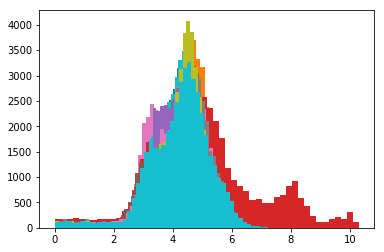

In [234]:
k = 300
n = 175

# overlap rate of almost 2.625 (each letter is sampled 2.625 times)
# 300 samples of 175 characters for each of 20 documents = 6000 samples

D3_a = []
for i in range(len(three_unshuffled)):
    M_i = streak(three_unshuffled[i][0], k, n, Smooth=.01) # make a streak
    d_i = psKLD(M_i, k) # do the pointwise psKLDs
    D3_a.append(d_i)
    
D3_a = np.array(D3_a)

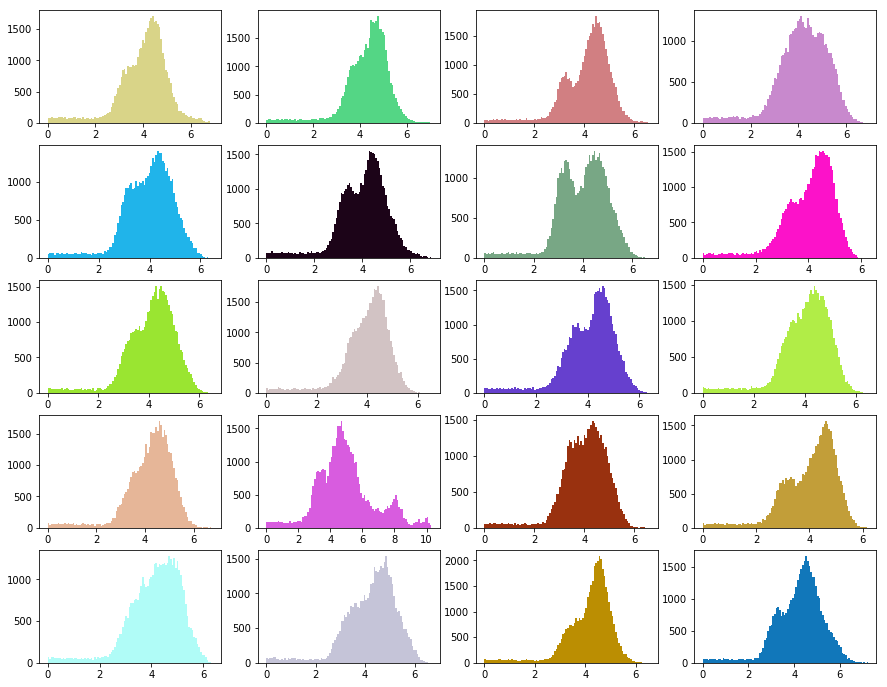

In [318]:
cols = 4
f, axarr = plt.subplots(5, cols, figsize=(15,12)) # 5 rows, 4 cols for 20 doc histograms in corpus
for i in range(D3_a.shape[0]): # for each document
    coor = index_to_coord(i, cols)
    color = list(np.random.rand(3))
    axarr[coor[0], coor[1]].hist(D3_a[i], bins=100, color = color) # can go as high as 300 bins  

There are a few things we can eek out of these larger documents. First and foremost is that if there is some sort of identity histogram $I$ which represents the psKLD histogram of a monolingual document, and which is consistent across all languages, then we can try to remove it from the histograms above. This would then amplify the signal of the other psKLD Gaussians, which would give us a better insight into how many modes are in the histogram, which would thus tell us how many languages are present. Second, when trying to fit a best Gaussian mixture model to the histograms, we won't be fitting $n$ Gaussians, but $\binom{n}{2} + 1$ Gaussians, which correspond to each psKLD difference between the languages present. Finally, notice that they all still share that left skew from 0 to 2. Not sure why yet, but I want to compare whether they are all coming from the same histogram distribution via the Anderson-Darling goodness of fit measure. Note that these should be intrinsically tied to the multinomial distributions which we generated earlier. Each document histogram here might simply be a Gaussian mixture given by
$$
M = p_1 p_2 D_{\ell_1, \ell_2} + p_2 p_3 D_{\ell_1, \ell_3} + \cdots,
$$
or
$$
M = \sum_{i=1}^L \sum_{j=1}^L p_i p_j D_{\ell_i, \ell_j},
$$
where $D_{\ell_i, \ell_j}$ is the random variable representing the psKLD between two languages. 

What about for mixed documents?

In [416]:
print two_shuffled[0]

the united nations its agencies and the world bank are mobilising to strengthen international therapeutic solidarity el artículo 20 me otorga ese poder pero de todas formas voy a preguntárselo a la cámara i would like to see the coordination of civil society in the country in question in the assessment of the implementation of gsp just as we have now agreed in the agreement with south korea preparations for cancún climate change conference 29 november 10 december european statistical governance advisory board vote report bowle los nuevos líderes políticos ucranianos también deben tener un sentido de la responsabilidad y empezar a implementar las reformas que se han quedado a medio camino desde la revolución naranja ro señor presidente la propuesta de resolución relativa al caso de los miembros del anterior gobierno de ucrania es necesaria para garantizar el respeto de los principios básicos de la unión europea empezando por el respeto de los derechos humanos después de un año de progre

In [ ]:
k = 300
n = 175

# overlap rate of almost 2.625 (each letter is sampled 2.625 times)
# 300 samples of 175 characters for each of 20 documents = 6000 samples
D2_s = []
for i in range(len(two_shuffled)):
    M_i = streak(two_shuffled[i], k, n, Smooth=.01) # make a streak
    d_i = psKLD(M_i, k) # do the pointwise psKLDs
    D2_s.append(d_i)
    
D2_s = np.array(D2_s)

In [413]:
print D2_s

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


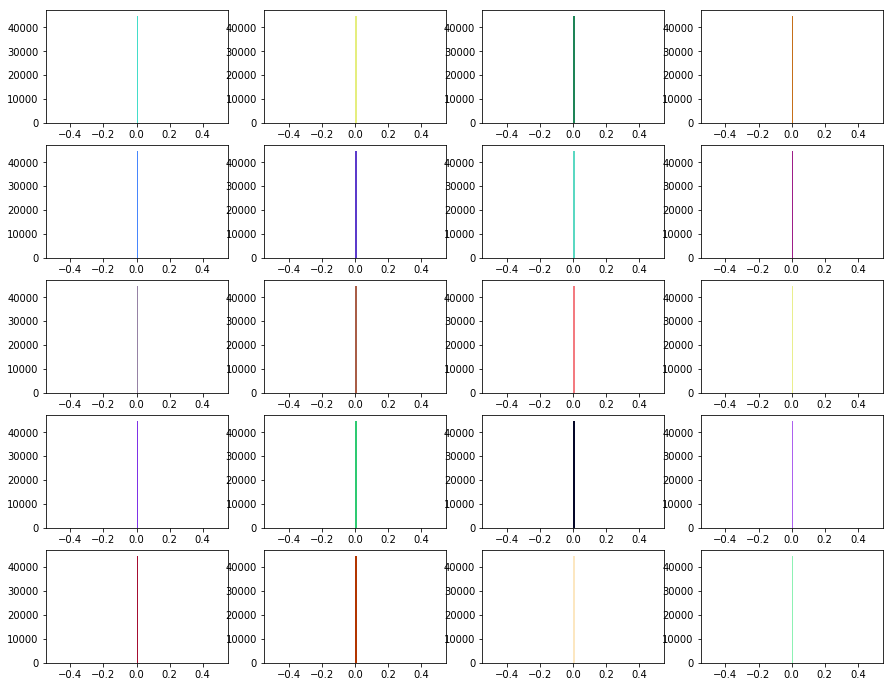

In [412]:
cols = 4
f, axarr = plt.subplots(5, cols, figsize=(15,12)) # 5 rows, 4 cols for 20 doc histograms in corpus
for i in range(D2_s.shape[0]): # for each document
    coor = index_to_coord(i, cols)
    color = list(np.random.rand(3))
    axarr[coor[0], coor[1]].hist(D2_s[i], bins=100, color = color) # can go as high as 300 bins  

## VMS
Let's now run this on the Voynich. We can first treat each folio in VMS as a document in a corpus, and then we can also treat VMS as a single document. This will thus determine whether VMS is in one language, and whether each folio is in one language. It might later be able to let us identify which folio is in which language.

In [333]:
FolioCorpus = [ ' '.join(folio) for folio in FOLIOS ]
VMS = ' '.join(T_vms)

In [379]:
FolioLength = np.array([ len(folio) for folio in FolioCorpus ])
print FolioLength
print 'avg folio length: ' + str(np.mean(FolioLength))

[ 735  585 1220 1237  713  809  796 1051 3288 2683 2856 3004 2322 2437
 2758 2817 3012 2831 3108 3639  525  322 3894 3437 2371 2644 3406 3032
 2953 2461 2883 2642 3094  310  257  429  358  425  399  524  378  458
  433  444  774  496  367  418  442 1195  481  558  478  592  337  619
  450  575  496  563  480  299  343  517  550  476  343  412  375  370
  522  553  348  581  403  617  641  434  461  433  554  815  703  547
  510  344  413  448  547  237  333  922  765  676  468  526  612  634
  421  827  629  904  914  437  552  487  450  949  659  433  478  559
  712  670  936  387  502  557  600  564  504  391  459  322  468  567
  515  677  576  592  527  571  626 2280 2172  322  277   14  259 2026
  700  955 1070  483  359  458  554  677  567  660 1000  874  758  478
  630  672 1377  561  813  572  588  647  666 1039  652  719  763  620
  606 2414 2035 3276 2528 2094 2039 1736 1649 2257 2151  406  436 2675
 2208 1193 1487 1867 1969 2205 1659 2151 1979 2126  951 1791 1120 2200
 2908 

(array([5.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 5.000e+00, 4.000e+00, 9.000e+00,
        1.200e+01, 3.000e+01, 5.200e+01, 9.200e+01, 1.110e+02, 1.470e+02,
        2.300e+02, 3.110e+02, 3.980e+02, 4.980e+02, 5.980e+02, 7.150e+02,
        8.230e+02, 9.330e+02, 1.051e+03, 1.109e+03, 1.215e+03, 1.308e+03,
        1.348e+03, 1.404e+03, 1.571e+03, 1.554e+03, 1.628e+03, 1.617e+03,
        1.583e+03, 1.629e+03, 1.662e+03, 1.589e+03, 1.560e+03, 1.551e+03,
        1.447e+03, 1.361e+03, 1.309e+03, 1.213e+03, 1.191e+03, 1.010e+03,
        1.012e+03, 9.050e+02, 8.100e+02, 7.460e+02, 6.730e+02, 5.940e+02,
        5.600e+02, 5.210e+02, 4.330e+02, 3.860e+02, 3.530e+02, 2.900e+02,
        2.450e+02, 2.380e+02, 1.930e+02, 1.480e+02, 1.210e+02, 1.240e+02,
        1.040e+02, 9.500e+01, 7.500e+01, 4.500e+01, 5.000e+01, 4.900e+01,
        3.600e+01, 3.400e+01, 2.800e+01, 7.000e+00, 1.700e+01, 9.000e+00,
        1.500e+01, 1.100e+01, 7.000e+0

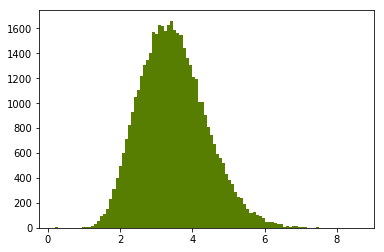

In [365]:
k = 300
n = 175

M_v = streak(T_vms, k, n, Smooth=.01)
psKLD_v = psKLD(M_v, k)

plt.hist(psKLD_v, bins=100, color = list(np.random.rand(3)))

In [380]:
print np.median(psKLD_v)

3.4134021506503878


So it looks like the Voynich is a set of mixed documents, or is in one language. Let's look at each folio.

(225, 1225)


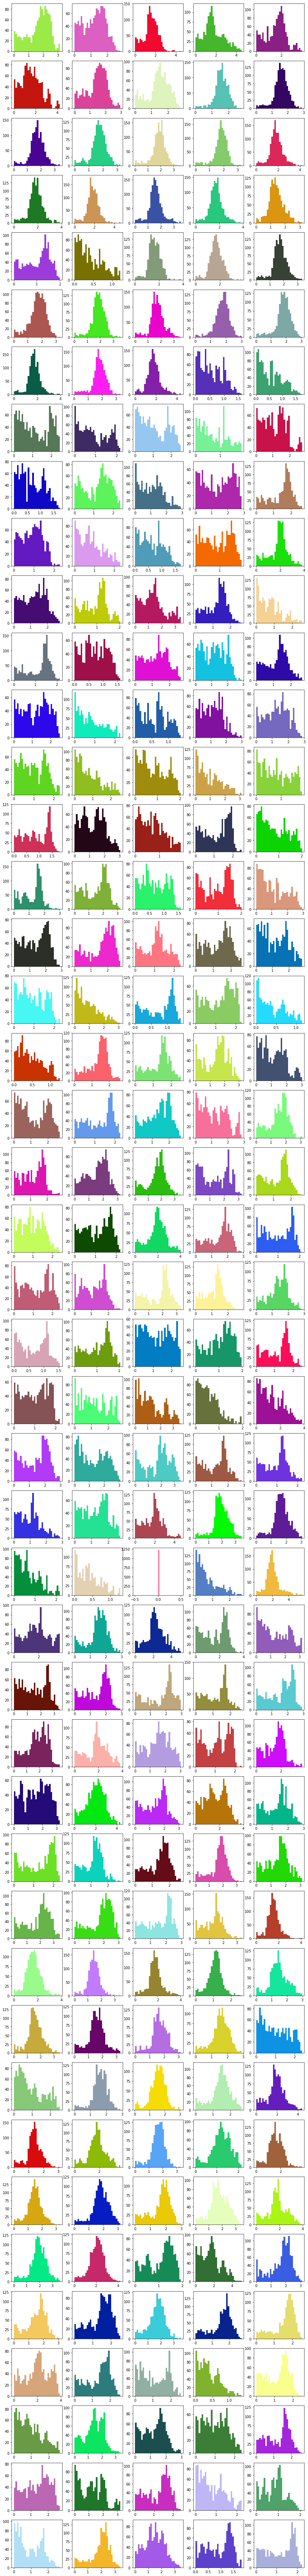

In [368]:
k = 50
n = 150

# overlap rate of almost 2.625 (each letter is sampled 2.625 times)
# 300 samples of 175 characters for each of 20 documents = 6000 samples

F = []
for i in range(len(FolioCorpus)):
    M_i = streak(FolioCorpus[i], k, n, Smooth=.01) # make a streak
    d_i = psKLD(M_i, k) # do the pointwise psKLDs
    F.append(d_i)
    
F = np.array(F)    

print F.shape

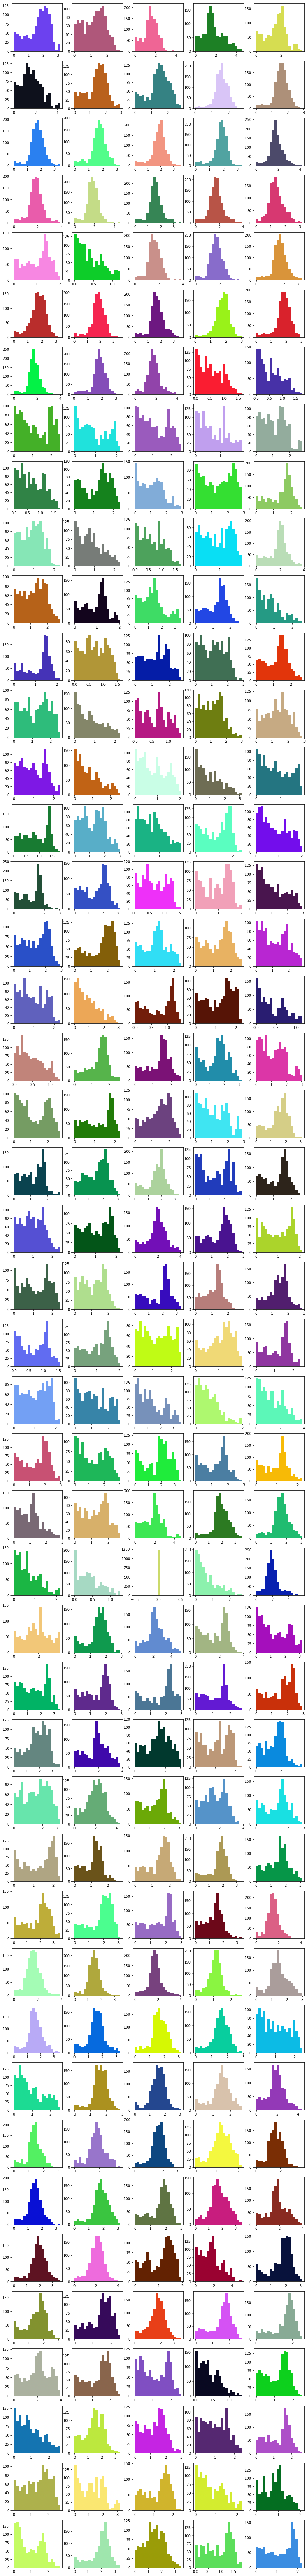

In [369]:
cols = 5
f, axarr = plt.subplots(45, cols, figsize=(15,135)) # 45 rows, 5 cols for 225 folio histograms in namuscript
for i in range(F.shape[0]): # for each folio
    coor = index_to_coord(i, cols)
    color = list(np.random.rand(3))
    axarr[coor[0], coor[1]].hist(F[i], bins=20, color = color) # can go as high as 300 bins  


Assumption: each document is in a mix of at least two languages. But if each document is in one language, but the corpus is in multiple languages, we'd still only see unimodal histograms.

# Discussion
What is the sensitivity of our test? Consider that in any sample substring of length $n$, the presence of a single $b$-length word will only lead to $b+2$ indicators in the bigram. This can easily be drowned out, since $\frac{b+2}{n}$ quickly approaches 0. For example, in English, the [average word length is 5.1 letters](https://arxiv.org/pdf/1208.6109.pdf), which means that in a substring of length $n=500$, a single Spanish word would only account for about 1% of the bigram. 

What is the rate of convergence to the mean? That is, how long must our substring be to get within $\alpha$% of the language's bigram?

Trigram models perform optimally. "For the bigraph model, optimal success (100%) was reached on text samples of 200 characters or more, whereas for the trigraph model, 100% success could be gained on samples of more than 175 characters." [link](https://www.researchgate.net/publication/246922625_Natural_language_identification_using_corpus-based_models) 

"Whereas, for a trigraph model, only 25-50% of the \[tri\]graphs need to be learned to achieve optimal recognition"[link](https://tidsskrift.dk/her/article/view/25083)

What if we boosted the words that appeared abberant? 

We need to bootstrap so that we can estimate variance of the bigrams.

Zipf's law: The frequency of a word is inversely proportional to its rank of usage. Derives from a Pareto distribution. The first place word is used about twice as much as the second, three times as much as the third, etc. 

Formally,
$$
P(W=w) \propto \frac{1}{(r_w+\beta)^{\alpha}},
$$
where $r$ is the rank of the usage of word $w$, and $\alpha$ and $\beta$ are shaping parameters.

Rehurek and Kolkus, 2009: 372/619


hapax legomenon

2-d table, where one axis modifies the substring length, and other modifies the number of clusters?

Can we justify using a Gaussian Mixture Model as a clustering algorithm?
- must assume that language bigrams have a mean, and that variation from the mean is from Gaussian white noise
- and Prof said its legit

kl divergence
cut points
monte carlo markov chains
linear vs optimal time 
parameter estimation
variable order markov model or context tree mm

Find the cut between samples which minimizes the variance in each section.

# References
[statistical identification of language](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.48.1958&rep=rep1&type=pdf)

[natural language identification using corpus based methods](https://tidsskrift.dk/her/article/view/25083)

[Zipf's Law in word frequency](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4176592/)

[Automatic Language Classification by means of Syntactic Dependency Networks](https://www.tandfonline.com/doi/full/10.1080/09296174.2011.608602?src=recsys)

[Model generation for word length frequencies in texts with the application of Zipf's order approach](https://www.tandfonline.com/doi/full/10.1080/09296174.2012.714531?src=recsys)

[Natural language identification using corpus-based models](https://www.researchgate.net/publication/246922625_Natural_language_identification_using_corpus-based_models?enrichId=rgreq-d97128a2b63639546ad910327bdb675e-XXX&enrichSource=Y292ZXJQYWdlOzI0NjkyMjYyNTtBUzoxNzU3MTcyODMyNzg4NDhAMTQxODkwNTY3MzE5Mg%3D%3D&el=1_x_2&_esc=publicationCoverPdf)

[Reddy and Knight](https://www.isi.edu/natural-language/people/voynich-11.pdf) use HMMs (in passing) to claim that the manuscript is in two languages.

[Currier](http://www.voynich.nu/extra/curr_main.html) Hands A and B.

[Currier PCA](http://www.voynich.nu/extra/curabcd.html)

Statistical Identification of Language, Ted Dunning (1994).
Language Identification on the Web: Extending the Dictionary Method, Rehurek and Kolkus (2016).
Text Classifiation and segmentation using minimum cross-entropy, W.J. Teahan (2000).
Natural Language Identification using Corpus Based Models, Souter et al. (1994)
